In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines 


In [2]:
path = '/home/dkabe/Model_brainstorming/Output/Variable_vals/'

In [3]:
Manufacturing_plants = 6
Distribution = 4
Market = 29
num_Scenarios = 192
Products = 3
Outsourced = 3
rl = [0.5, 0.95]
r_level = 0.5

In [4]:
demand = np.loadtxt('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_1/Demand_1.txt').reshape((192, 3, 29))
text_file = open('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_1/scen_1.txt', "r")
ls = text_file.read().split('\n')[:-1]
Scen = list(map(lambda x: ast.literal_eval(x), ls))
f = open(path + "Instance_1/variable_vals_" +str(r_level) + ".txt", "r")
text = f.read()
f.close()
solutions_str = text.split('\n')
for i in solutions_str:
    exec(i.lstrip().rstrip())

In [5]:
print(v_val_x_i)
print(v_val_x_j)

{0: 0.0, 1: 1.0, 2: -0.0, 3: 1.0, 4: 1.0, 5: -0.0}
{0: 1.0, 1: 1.0, 2: -0.0, 3: 1.0}


In [9]:
indices = [130]#, 56]
for index in indices:
    print(Scen[index])

[[0, 0, 1, 1, 0, 0], (1, 1, 1, 1)]


/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


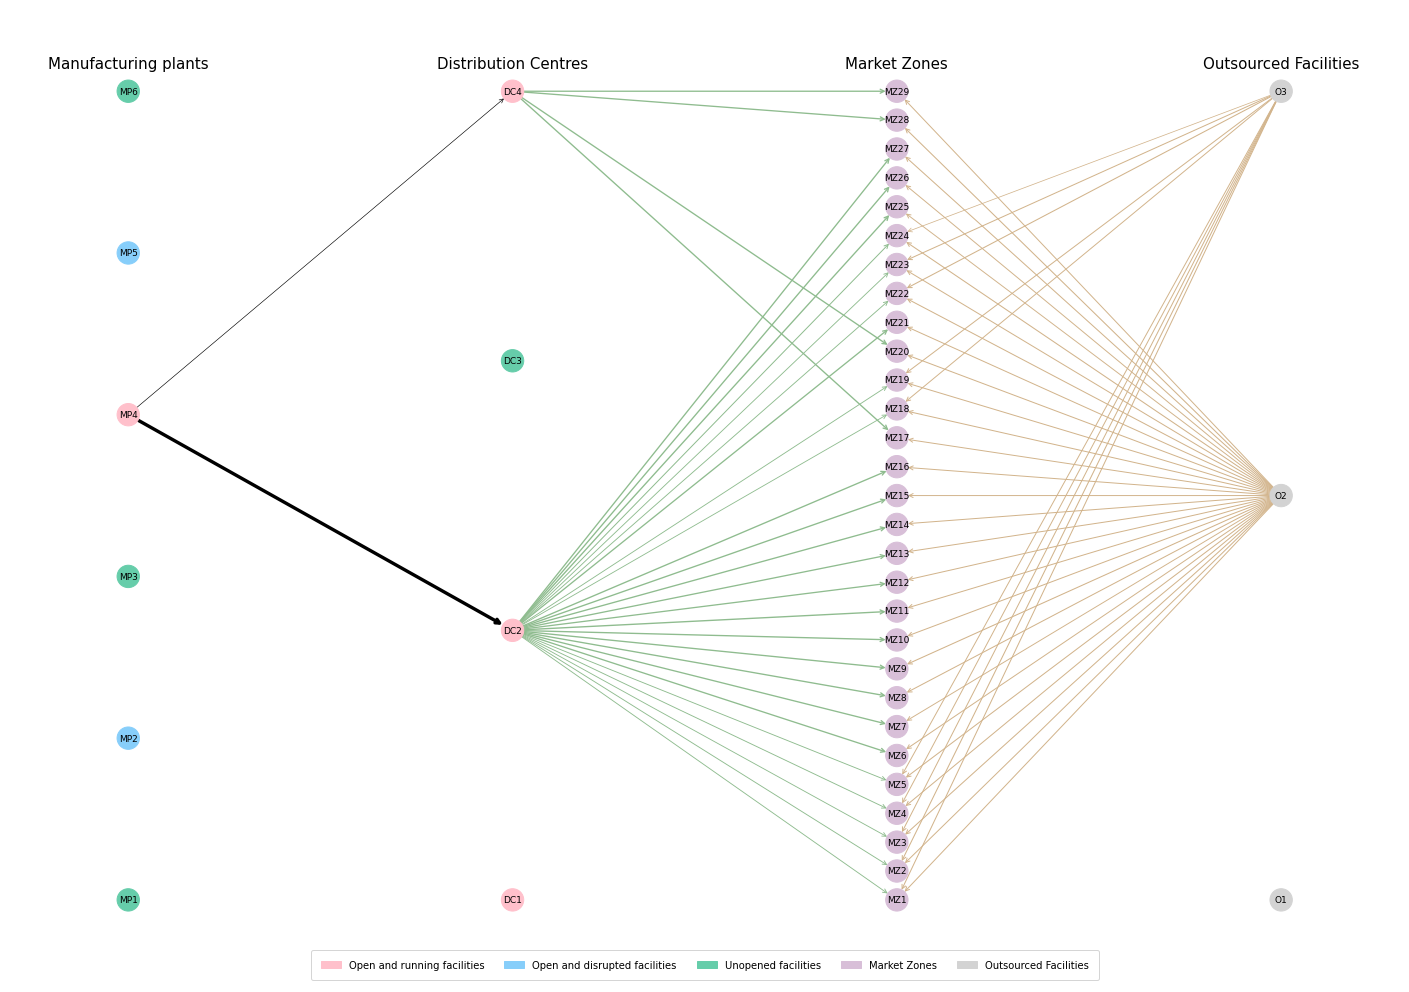

In [10]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])        

                
    Graph = nx.DiGraph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])        
        Graph.add_node(MP[i])
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Node_colors.append('pink')
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Node_colors.append('pink')
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('thistle')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

  
    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        Graph.add_node(O[l])
        Node_colors.append('lightgrey')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(O, Position_values)))

    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])
    Edge_colors.extend(['tan' for l in LK_edges])


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = True, font_size = 9, font_color = "black", node_size = 500, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')
    
    # Add Titles (invisible nodes to put text labels)
    position_mp = (0, 30)
    position_dc = (1, 30)
    position_mz = (2, 30)
    position_o = (3, 30)
    position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
    Graph.add_node("Manufacturing Plants")
    Graph.add_node("Distribution Centres")
    Graph.add_node("Market Zones")
    Graph.add_node("Outsourced Facilities")
    titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
    title_pos = dict(zip(titles, position_titles))
    label_titles = {}    
    for node in titles:
        label_titles[node] = node
    nx.draw_networkx_nodes(Graph, nodelist= titles, pos = title_pos, node_color = "white")
    nx.draw_networkx_labels(Graph, labels = label_titles, pos = title_pos, font_color = "black", font_size = 15)

    limits=plt.axis('off')
    plt.gcf().set_size_inches(25, 18)

    legend_mp_1 = mpatches.Patch(color = 'pink', label = 'Open and running facilities')
    legend_mp_2 = mpatches.Patch(color = 'lightskyblue', label = 'Open and disrupted facilities')
    legend_mp_3 = mpatches.Patch(color = 'mediumaquamarine', label = 'Unopened facilities')
    legend_mz = mpatches.Patch(color = 'thistle', label = 'Market Zones')
    legend_o = mpatches.Patch(color = 'lightgrey', label = 'Outsourced Facilities')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp_1, legend_mp_2, legend_mp_3, legend_mz, legend_o], ncol = 5, borderpad=1)

    plt.show()

/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:165: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


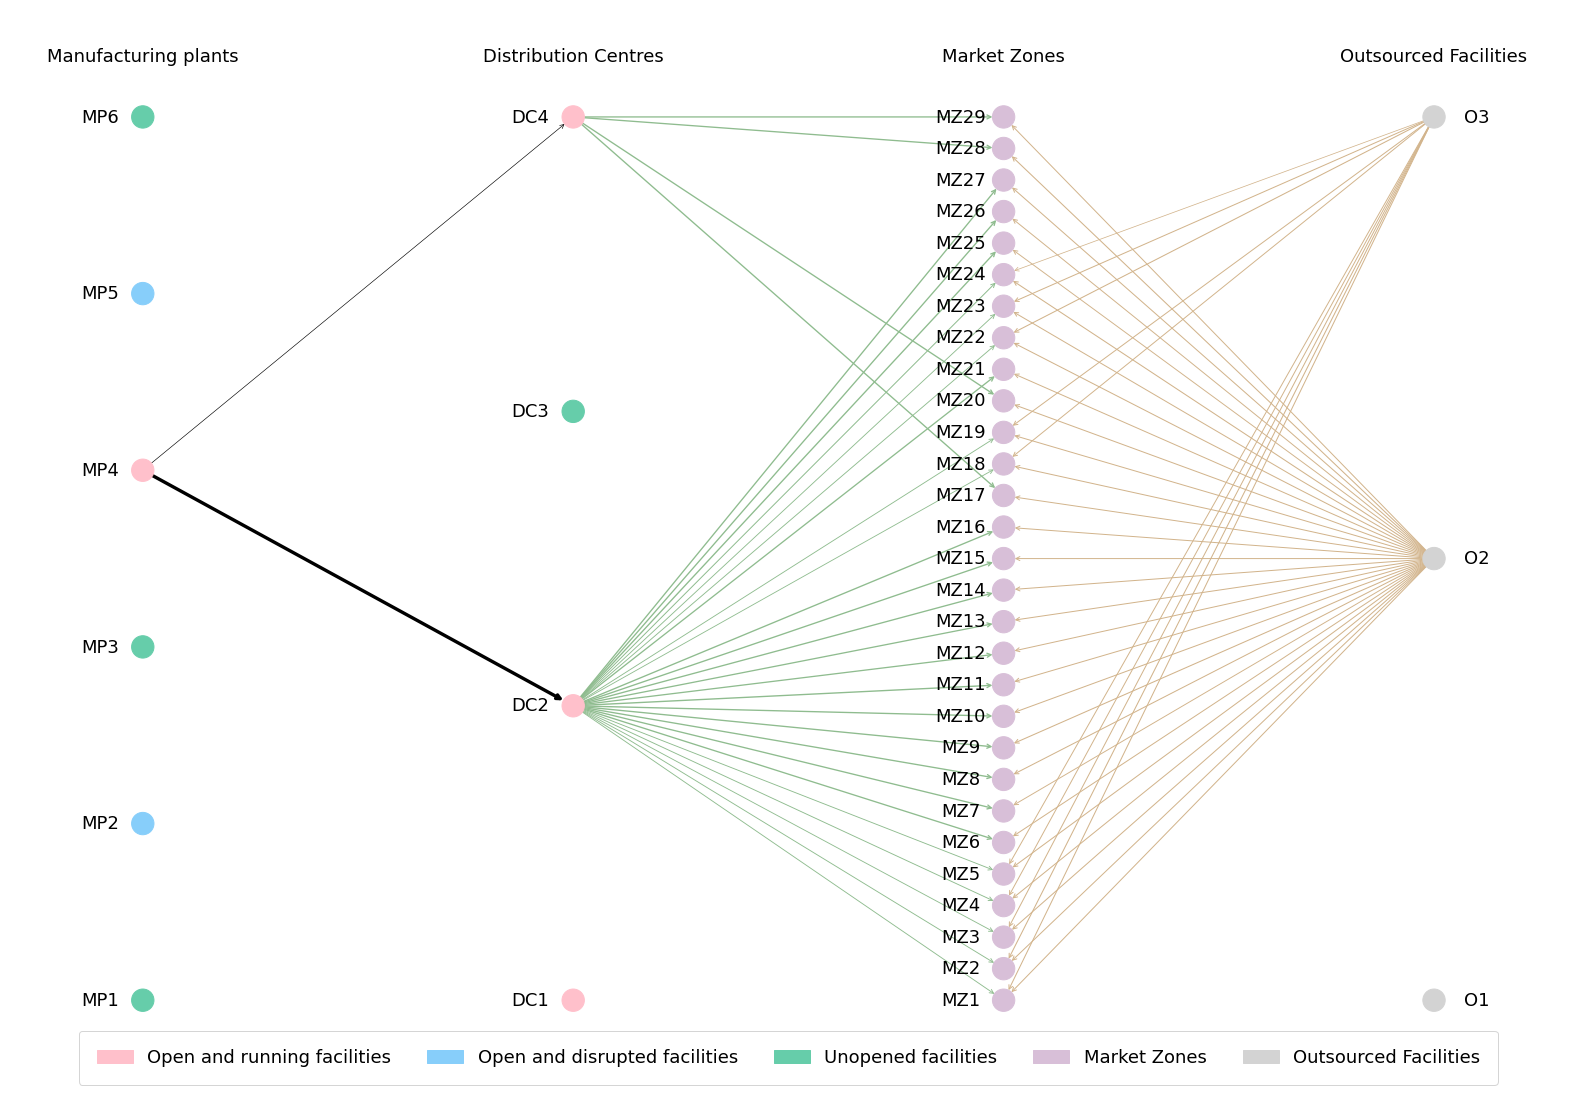

In [11]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])        

                
    Graph = nx.DiGraph()
    labels = []

    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])
        position_label = (-0.1, y_pos[i])        
        Graph.add_node(MP[i])
        labels.append(MP[i])
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Node_colors.append('pink')
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic = dict(zip(MP, Position_values))
    Position_labels = dict(zip(MP, Position_label_vals))

    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        position_label = (0.9, y_pos[j])     
        Graph.add_node(DC[j])        
        labels.append(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Node_colors.append('pink')
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic.update(dict(zip(DC, Position_values)))    
    Position_labels.update(dict(zip(DC, Position_label_vals)))

    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        position_label = (1.9, y_pos[k])   
        Graph.add_node(MZ[k])
        labels.append(MZ[k])
        Node_colors.append('thistle')
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic.update(dict(zip(MZ, Position_values)))
    Position_labels.update(dict(zip(MZ, Position_label_vals)))
  
    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        position_label = (3.1, y_pos[l])  
        Graph.add_node(O[l])        
        labels.append(O[l])
        Node_colors.append('lightgrey')
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic.update(dict(zip(O, Position_values)))
    Position_labels.update(dict(zip(O, Position_label_vals)))


    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])
    Edge_colors.extend(['tan' for l in LK_edges])


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = False, node_size = 500, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')
    nx.draw_networkx_labels(Graph, labels = None, pos = Position_labels, font_size = 18)

    # Add Titles (invisible nodes to put text labels)
    position_mp = (0, 31)
    position_dc = (1, 31)
    position_mz = (2, 31)
    position_o = (3, 31)
    position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
    Graph.add_node("Manufacturing Plants")
    Graph.add_node("Distribution Centres")
    Graph.add_node("Market Zones")
    Graph.add_node("Outsourced Facilities")
    titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
    title_pos = dict(zip(titles, position_titles))
    label_titles = {}    
    for node in titles:
        label_titles[node] = node
    nx.draw_networkx_nodes(Graph, nodelist= titles, pos = title_pos, node_color = "white")
    nx.draw_networkx_labels(Graph, labels = label_titles, pos = title_pos, font_color = "black", font_size = 18)

    limits=plt.axis('off')
    plt.gcf().set_size_inches(28, 20)

    legend_mp_1 = mpatches.Patch(color = 'pink', label = 'Open and running facilities')
    legend_mp_2 = mpatches.Patch(color = 'lightskyblue', label = 'Open and disrupted facilities')
    legend_mp_3 = mpatches.Patch(color = 'mediumaquamarine', label = 'Unopened facilities')
    legend_mz = mpatches.Patch(color = 'thistle', label = 'Market Zones')
    legend_o = mpatches.Patch(color = 'lightgrey', label = 'Outsourced Facilities')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp_1, legend_mp_2, legend_mp_3, legend_mz, legend_o], ncol = 5, borderpad=1, fontsize = 18)

    plt.savefig("network_visuals.pdf", bbox_inches="tight")
    plt.show()

In [29]:
Position_dic

{'MP1': array([0., 0.]),
 'MP2': array([0. , 5.8]),
 'MP3': array([ 0. , 11.6]),
 'MP4': array([ 0. , 17.4]),
 'MP5': array([ 0. , 23.2]),
 'MP6': array([ 0., 29.]),
 'DC1': array([1., 0.]),
 'DC2': array([1.        , 9.66666667]),
 'DC3': array([ 1.        , 19.33333333]),
 'DC4': array([ 1., 29.]),
 'MZ1': array([2., 0.]),
 'MZ2': array([2.        , 1.03571429]),
 'MZ3': array([2.        , 2.07142857]),
 'MZ4': array([2.        , 3.10714286]),
 'MZ5': array([2.        , 4.14285714]),
 'MZ6': array([2.        , 5.17857143]),
 'MZ7': array([2.        , 6.21428571]),
 'MZ8': array([2.  , 7.25]),
 'MZ9': array([2.        , 8.28571429]),
 'MZ10': array([2.        , 9.32142857]),
 'MZ11': array([ 2.        , 10.35714286]),
 'MZ12': array([ 2.        , 11.39285714]),
 'MZ13': array([ 2.        , 12.42857143]),
 'MZ14': array([ 2.        , 13.46428571]),
 'MZ15': array([ 2. , 14.5]),
 'MZ16': array([ 2.        , 15.53571429]),
 'MZ17': array([ 2.        , 16.57142857]),
 'MZ18': array([ 2.  

In [ ]:
## Without color

/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:151: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


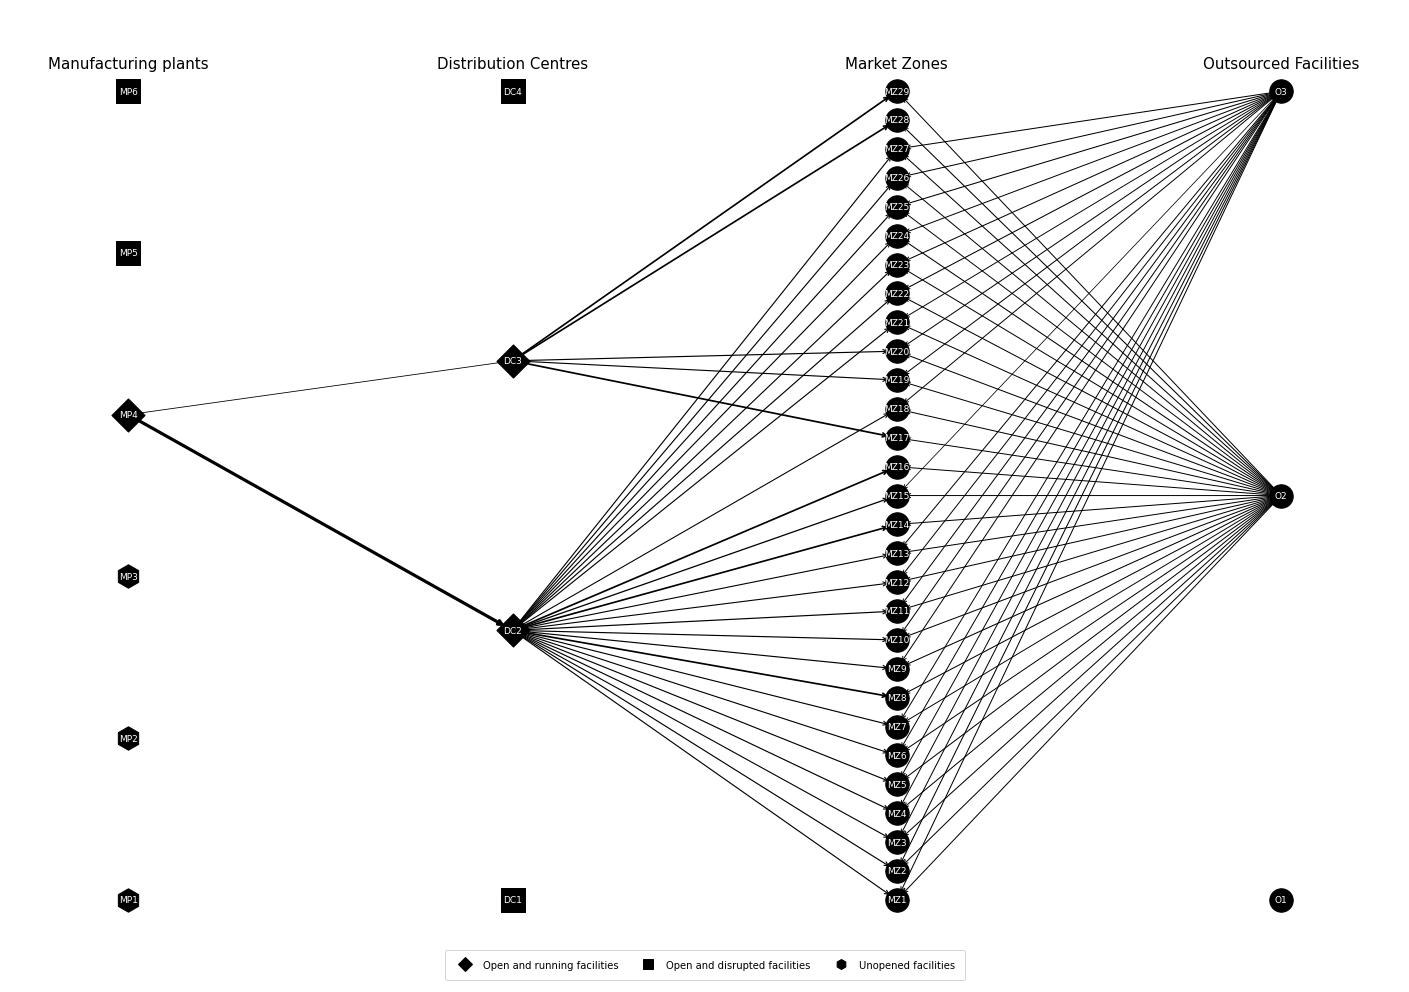

In [8]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_shapes = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])        

                
    Graph = nx.DiGraph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])        
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Graph.add_node(MP[i], s="D")
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Graph.add_node(MP[i], s="s")
        else:
            Graph.add_node(MP[i], s="h")
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Graph.add_node(DC[j], s="D")
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Graph.add_node(DC[j], s="s")
        else:
            Graph.add_node(DC[j], s="h")
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k], s = 'o')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

  
    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        Graph.add_node(O[l], s = 'o')
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(O, Position_values)))

    #labels = {}    
    #for node in Graph.nodes():
     #   labels[node] = node

    nodeShapes = set((aShape[1]["s"] for aShape in Graph.nodes(data = True)))
    for aShape in nodeShapes:
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
        nx.draw_networkx_nodes(Graph,Position_dic,node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,Graph.nodes(data = True))],node_size=550, node_color= "black")


    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx_edges(Graph, edge_color = "black", pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')
    nx.draw_networkx_labels(Graph, pos = Position_dic, font_color = "white", font_size = 9)

    # Add Titles (invisible nodes to put text labels)
    position_mp = (0, 30)
    position_dc = (1, 30)
    position_mz = (2, 30)
    position_o = (3, 30)
    position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
    Graph.add_node("Manufacturing Plants")
    Graph.add_node("Distribution Centres")
    Graph.add_node("Market Zones")
    Graph.add_node("Outsourced Facilities")
    titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
    title_pos = dict(zip(titles, position_titles))
    label_titles = {}    
    for node in titles:
        label_titles[node] = node
    nx.draw_networkx_nodes(Graph, nodelist= titles, pos = title_pos, node_color = "white")
    nx.draw_networkx_labels(Graph, labels = label_titles, pos = title_pos, font_color = "black", font_size = 15)


    limits=plt.axis('off')
    plt.gcf().set_size_inches(25, 18)

    diamond = mlines.Line2D([], [], linewidth = 0, color='black', marker='D',
                          markersize=10, label='Open and running facilities')
    
    square = mlines.Line2D([], [], linewidth = 0, color='black', marker='s',
                          markersize=10, label='Open and disrupted facilities')

    triangle = mlines.Line2D([], [], linewidth = 0, color='black', marker='h',
                          markersize=10, label='Unopened facilities')
      

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[diamond, square, triangle], ncol = 3, borderpad=1)

    plt.show()

In [46]:
nodeShapes = set((aShape[1]["s"] for aShape in Graph.nodes(data = True)))
[sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,Graph.nodes(data = True))]

KeyError: 's'

In [41]:
position_mp = (0, 0.1)
position_dc = (1, 0.1)
position_mz = (2, 0.1)
position_o = (3, 0.1)
position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
Graph.add_node("Manufacturing Plants")
Graph.add_node("Distribution Centres")
Graph.add_node("Market Zones")
Graph.add_node("Outsourced Facilities")
titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
title_pos = dict(zip(titles, position_titles))

{'Manufacturing plants': array([ 0. , 29.1]),
 'Distribution Centres': array([ 1. , 29.1]),
 'Market Zones': array([ 2. , 29.1]),
 'Outsourced Facilities': array([ 3. , 29.1])}

# Instance 2

In [9]:
import numpy as np
r_level = 0.5
demand = np.loadtxt('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_2/Demand_2.txt').reshape((192, 3, 29))
text_file = open('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_2/scen_2.txt', "r")
ls = text_file.read().split('\n')[:-1]
Scen = list(map(lambda x: ast.literal_eval(x), ls))
f = open(path + "Instance_2/variable_vals_" +str(r_level) + ".txt", "r")
text = f.read()
f.close()
solutions_str = text.split('\n')
for i in solutions_str:
    exec(i.lstrip().rstrip())
num_Scenarios = 192


In [11]:
print(v_val_x_i)
print(v_val_x_j)


{0: 1.0, 1: 0.0, 2: 1.0, 3: -0.0, 4: 1.0, 5: 1.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [66]:
#indices = [0, 3]
indices = [16]
for index in indices:
    print(Scen[index])

[[0, 1, 1, 0, 0, 1], (0, 1, 1, 0)]


/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


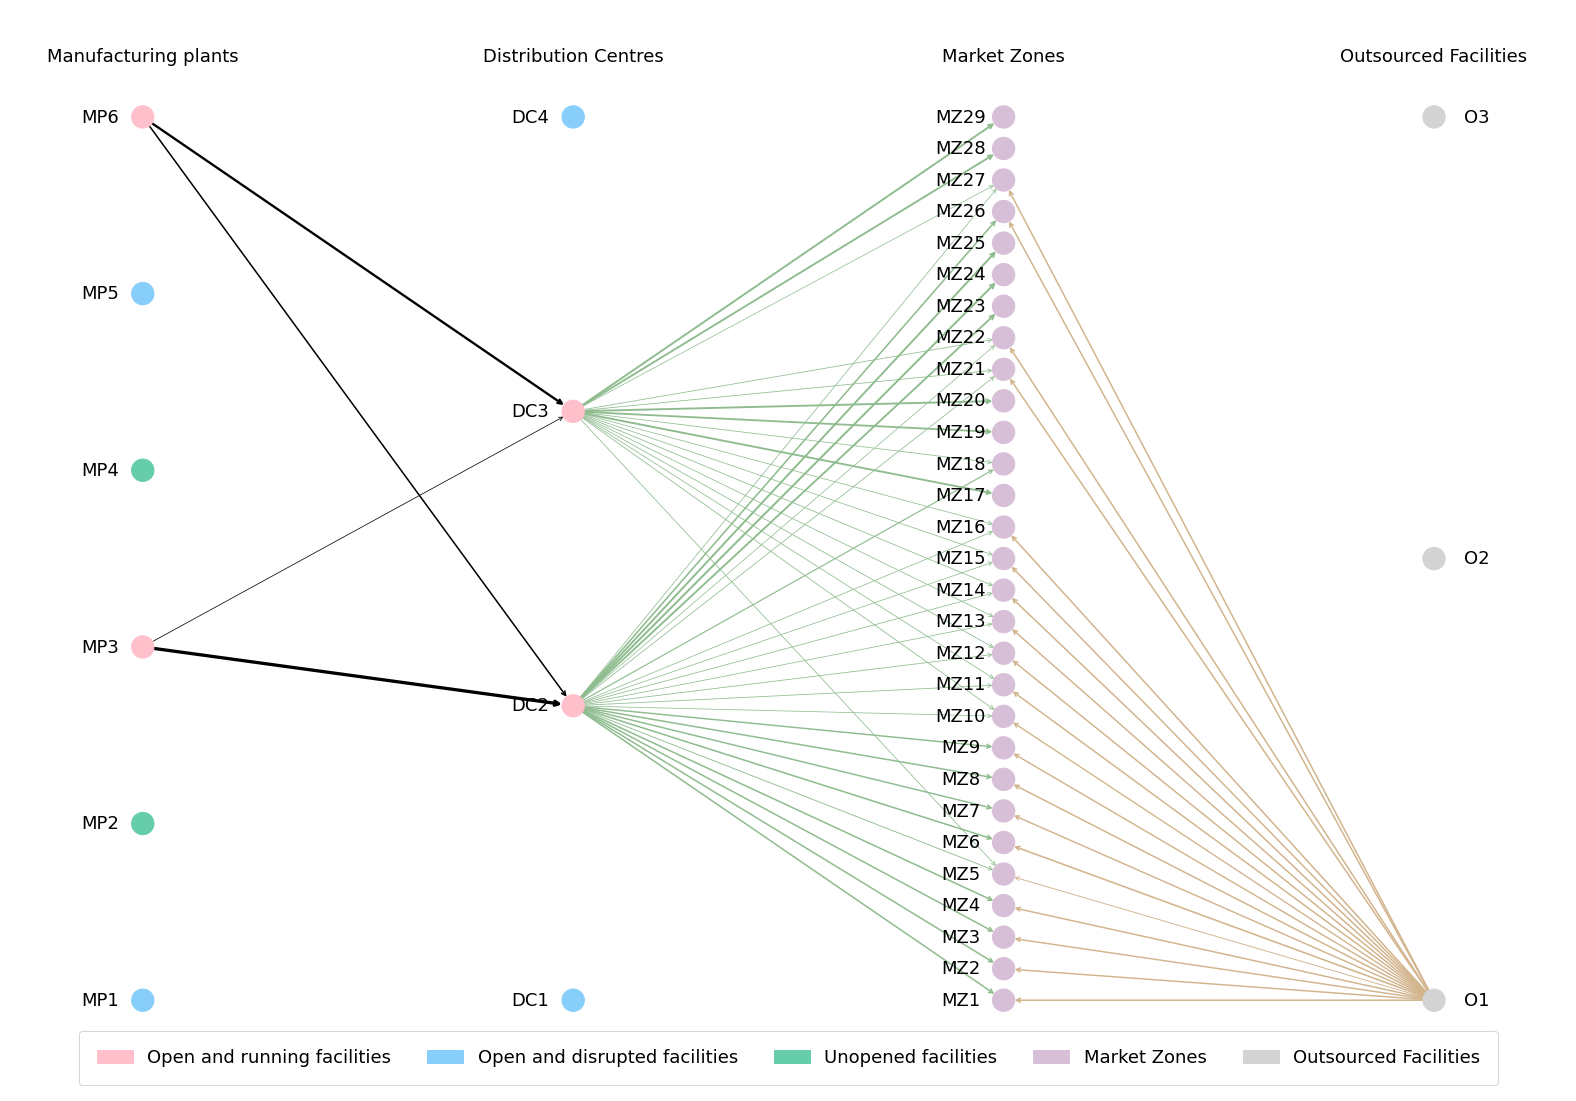

In [67]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    if max(Weight_lk) == 0:
        div_val = 1
    else:
        div_val = max(Weight_lk)
    for l in range(Outsourced):
        for k in range(Market):
            if T2[l][k]/div_val < 1:
                Weight.append(29*T2[l][k]/(div_val))
            else:
                Weight.append(T2[l][k]/(div_val))
                
    Graph = nx.DiGraph()
    labels = []

    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])
        position_label = (-0.1, y_pos[i])        
        Graph.add_node(MP[i])
        labels.append(MP[i])
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Node_colors.append('pink')
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic = dict(zip(MP, Position_values))
    Position_labels = dict(zip(MP, Position_label_vals))

    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        position_label = (0.9, y_pos[j])     
        Graph.add_node(DC[j])        
        labels.append(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Node_colors.append('pink')
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Node_colors.append('lightskyblue')
        else:
            Node_colors.append("mediumaquamarine")
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic.update(dict(zip(DC, Position_values)))    
    Position_labels.update(dict(zip(DC, Position_label_vals)))

    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        position_label = (1.9, y_pos[k])   
        Graph.add_node(MZ[k])
        labels.append(MZ[k])
        Node_colors.append('thistle')
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic.update(dict(zip(MZ, Position_values)))
    Position_labels.update(dict(zip(MZ, Position_label_vals)))
  
    Position_values = []
    Position_label_vals = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        position_label = (3.1, y_pos[l])  
        Graph.add_node(O[l])        
        labels.append(O[l])
        Node_colors.append('lightgrey')
        Position_values.append(np.asarray(position))
        Position_label_vals.append(np.asarray(position_label))
    Position_dic.update(dict(zip(O, Position_values)))
    Position_labels.update(dict(zip(O, Position_label_vals)))


    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])
    Edge_colors.extend(['tan' for l in LK_edges])


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = False, node_size = 500, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')
    nx.draw_networkx_labels(Graph, labels = None, pos = Position_labels, font_size = 18)

    # Add Titles (invisible nodes to put text labels)
    position_mp = (0, 31)
    position_dc = (1, 31)
    position_mz = (2, 31)
    position_o = (3, 31)
    position_titles = [np.asarray(position_mp), np.asarray(position_dc), np.asarray(position_mz), np.asarray(position_o)]
    Graph.add_node("Manufacturing Plants")
    Graph.add_node("Distribution Centres")
    Graph.add_node("Market Zones")
    Graph.add_node("Outsourced Facilities")
    titles = ["Manufacturing plants", "Distribution Centres", "Market Zones", "Outsourced Facilities"]
    title_pos = dict(zip(titles, position_titles))
    label_titles = {}    
    for node in titles:
        label_titles[node] = node
    nx.draw_networkx_nodes(Graph, nodelist= titles, pos = title_pos, node_color = "white")
    nx.draw_networkx_labels(Graph, labels = label_titles, pos = title_pos, font_color = "black", font_size = 18)

    limits=plt.axis('off')
    plt.gcf().set_size_inches(28, 20)

    legend_mp_1 = mpatches.Patch(color = 'pink', label = 'Open and running facilities')
    legend_mp_2 = mpatches.Patch(color = 'lightskyblue', label = 'Open and disrupted facilities')
    legend_mp_3 = mpatches.Patch(color = 'mediumaquamarine', label = 'Unopened facilities')
    legend_mz = mpatches.Patch(color = 'thistle', label = 'Market Zones')
    legend_o = mpatches.Patch(color = 'lightgrey', label = 'Outsourced Facilities')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp_1, legend_mp_2, legend_mp_3, legend_mz, legend_o], ncol = 5, borderpad=1, fontsize = 18)

    plt.savefig("network_visuals_2.pdf", bbox_inches="tight")
    plt.show()

In [33]:
div_val

1

In [49]:
new_mat = np.sum(np.sum(T2_mat, axis=1),axis=1)

In [50]:
new_mat.shape

(192, 29)

In [55]:
for scen in range(len(new_mat)):
    if sum(new_mat[scen]) > 0:
        print(scen)

0
3
5
8
10
11
13
16
17
20
21
22
31
32
34
35
37
39
40
41
43
44
45
46
47
49
50
52
53
54
55
56
57
58
59
60
61
62
63
64
66
67
70
71
72
73
74
75
76
78
81
87
88
89
90
91
92
93
94
95
96
97
98
100
101
102
103
105
106
107
110
111
114
115
116
117
120
121
122
123
125
127
129
130
131
132
133
134
136
138
140
141
142
144
145
147
148
149
150
151
152
154
155
156
159
162
164
165
166
167
168
169
170
171
172
173
176
177
178
179
180
182
184
185
186
187
188
190


In [58]:
new_mat[5]

array([142767.3475, 142699.8275, 137250.225 , 140838.28  ,  71629.225 ,
       145437.025 , 136706.3725, 139671.45  , 133168.43  , 133003.85  ,
       212298.705 , 213739.835 , 208178.4025, 217083.6575, 138205.    ,
       141254.4775, 139079.595 ,  73500.795 ,  64545.955 ,  69964.435 ,
        88191.6575, 142539.17  ,  64720.16  , 149107.8975, 214739.4475,
       143261.0875, 206139.0875,  67236.205 ,  73042.3975])

In [69]:
Y

array([[      0.        ,       0.        ,       0.        ,
              0.        ],
       [      0.        ,       0.        ,       0.        ,
              0.        ],
       [      0.        , 3738937.74619344,  841569.79185389,
              0.        ],
       [      0.        ,       0.        ,       0.        ,
              0.        ],
       [      0.        ,       0.        ,       0.        ,
              0.        ],
       [      0.        , 1759523.04      , 2679479.9635872 ,
              0.        ]])